In [1]:
import utility
import pandas as pd
import numpy as np

import yaml
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
# mpl.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'serif'  # Use Computer Modern fonts
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts}'


contri = ['spearman', 'mse']

# Define color palette
palette = list(sns.color_palette("Set2")[:3]) + ['tab:red', 'tab:brown', 'tab:purple', 'tab:pink']


# Define the custom orders
SYSTEM_ORDER = ["p38", "tyk2"]
FORCE_FIELD_ORDER = ['espaloma-0.3.1', 'gaff-2.11', 'openff-2.0.0', 'Khalak2021', 'Lin2021', 'Chen2023', 'Li2019']
FF_NAME = {
    'espaloma-0.3.1': 'Espaloma', 
    'gaff-2.11': 'GAFF',
    'openff-2.0.0': 'OpenFF',
    'Lin2021': 'Lin et al. 2021',
    'Chen2023': 'Chen et al. 2023',
    'Khalak2021': 'Khalak et al. 2021',
    'Li2019': 'Li et al. 2019'
}
SYSTEM_NAME = {
    "p38": "P38", 
    "tyk2": "TYK2",
}


def to_latex(string):
    try:
        return r"$\mathrm{" + string.replace("_", r"\_").replace("-", r"-").replace(" ", r"\ ") + r"}$"
    except:
        raise Exception(string)


def plot_stats(ax, data, contribution='spearman', legend = 'auto'):
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    values = dat2work[contribution].apply(utility.get_numerical_values)
    values = np.array(list(values.values))
    
    ci_low = []
    ci_high = []
    nominal_value = []
    for v, l, h in values:
        if v:
            nominal_value.append(v)
            ci_low.append(v - l)
            ci_high.append(h - v)
        else:
            nominal_value.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)

    dat2work['ci_low'] = ci_low
    dat2work['ci_high'] = ci_high
    dat2work[contribution] = nominal_value
    
    # dat2work['ci_low'] = values[:,0] - values[:,1]
    # dat2work['ci_high'] = values[:,2] - values[:,0]
    # dat2work['value'] = values[:,0]

    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )

    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    bar_plot = sns.barplot(
        data=dat2work,
        x="source",
        y=contribution,
        hue='force_field',
        width=0.85,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )

    # Those are the patch used on the legend and attached at the end
    num_unique_ff = len(dat2work["force_field"].unique())
    # [:-num_unique_ff] ensures that only the patches of the real bars are considered
    if legend:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches[:-num_unique_ff]])
    else:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches])
    dat2work.dropna(inplace=True)
    ax.errorbar(
        x=bar_positions,  # Position of the bar
        y=dat2work[contribution],
        yerr=[dat2work['ci_low'], dat2work['ci_high']],
        fmt='none',  # No marker
        c='gray',
        capsize=5
    )

    if contribution == 'pearson':
        ax.set(
            ylabel=r'$\rho$'
        )
    if contribution == 'spearman':
        ax.set(
            ylabel=r'$r_S$'
        )
    if contribution == 'kendall':
        ax.set(
            ylabel=r'$\tau$'
        )
        
    ax.set(xlabel='')


def plot_ff(ax, data, contribution, legend = None):
    
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )
    
    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    sns.boxplot(
        x="source",
        y=contribution,
        hue='force_field',
        data=dat2work,
        whis=1.5, #[0, 100],
        width=0.85,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )
    if contribution == 'diff':
        ax.set(
            ylabel=r'$\Delta G_\mathrm{calc} - \Delta G_\mathrm{exp} \mathrm{~[kcal/mol]}$'
        )

    ax.set(xlabel='')

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
CALC_TYPE = "mbar"

BindFlowData = pd.read_csv("../data/simulation/bindflow/gather/BindFlow.csv")

columns = [
    "system",
    "ligand",
    "replica",
    "sample",
    "exp_dG",
    "exp_dG_error",
    f"simulation_{CALC_TYPE}_espaloma-0.3.1",
    f"simulation_{CALC_TYPE}_gaff-2.11",
    f"simulation_{CALC_TYPE}_openff-2.0.0",
    "simulation_Lin2021",
    "error_Lin2021",
    "simulation_Khalak2021",
    "error_Khalak2021",
    "simulation_Chen2023",
    "simulation_mbar_Li2019"
]
BindFlowData = BindFlowData[columns]


BindFlowData.rename(
    columns={
        "system": "source",
        f"simulation_{CALC_TYPE}_espaloma-0.3.1": "simulation_espaloma-0.3.1",
        f"simulation_{CALC_TYPE}_gaff-2.11": "simulation_gaff-2.11",
        f"simulation_{CALC_TYPE}_openff-2.0.0": "simulation_openff-2.0.0",
        "simulation_mbar_Li2019": "simulation_Li2019"
    },
    inplace=True
)

# Only consider 3 replicas
BindFlowData = BindFlowData[BindFlowData["replica"] <= 3]

mean = BindFlowData.groupby(["source", "ligand"]).mean().reset_index().drop(columns=["replica", "sample"])
sem = BindFlowData.groupby(["source", "ligand"]).sem().reset_index().drop(columns=["replica", "sample"])

# Filter DataFrame
mask = mean["simulation_espaloma-0.3.1"].notna() & mean["simulation_Lin2021"].notna() & mean["simulation_Khalak2021"].notna() & mean["simulation_Chen2023"].notna()


mean = mean[mask]
sem = sem[mask]


sem.rename(
    columns={
        "simulation_espaloma-0.3.1": "sem_espaloma-0.3.1",
        "simulation_gaff-2.11": "sem_gaff-2.11",
        "simulation_openff-2.0.0": "sem_openff-2.0.0",
        "simulation_Chen2023": "sem_Chen2023",
    },
    inplace=True
)

sem.drop(columns=["exp_dG", "exp_dG_error", "simulation_Lin2021", "simulation_Khalak2021", "error_Lin2021", "error_Khalak2021", "simulation_Li2019"], inplace=True)
# sem.drop(columns=["exp_dG", "exp_dG_error", "simulation_Lin2021", "simulation_Khalak2021", "error_Lin2021", "error_Khalak2021"], inplace=True)
sem["sem_Lin2021"] = mean["error_Lin2021"]
sem["sem_Khalak2021"] = mean["error_Khalak2021"]
mean.drop(columns=["error_Lin2021", "error_Khalak2021"], inplace=True)

df_merge = pd.merge(mean, sem, on=["source", "ligand"])
df_merge["sem_Li2019"] = 0
df_merge




,source,ligand,exp_dG,exp_dG_error,simulation_espaloma-0.3.1,simulation_gaff-2.11,simulation_openff-2.0.0,simulation_Lin2021,simulation_Khalak2021,simulation_Chen2023,simulation_Li2019,sem_espaloma-0.3.1,sem_gaff-2.11,sem_openff-2.0.0,sem_Chen2023,sem_Lin2021,sem_Khalak2021,sem_Li2019
0,p38,lig_p38a_2aa,-9.34,0.25,-11.753859,-11.094771,-12.412487,-15.489360,-10.611855,-15.067400,NaN,1.273073,0.548763,0.487229,0.145342,0.520280,0.669216,0
1,p38,lig_p38a_2bb,-9.13,0.20,-15.582165,-10.938932,-13.190718,-14.685880,-8.962715,-14.151100,NaN,1.700871,0.749087,0.746642,0.239970,0.754931,0.908222,0
2,p38,lig_p38a_2e,-10.78,0.26,-14.284328,-11.222684,-12.917581,-15.637480,-11.113767,-16.254433,NaN,0.178119,0.198333,0.938563,0.071072,0.843214,0.597514,0
3,p38,lig_p38a_2ee,-12.35,0.36,-15.006715,-13.012480,-14.083784,-16.961400,-10.325048,-16.302333,NaN,1.760016,0.997007,1.671187,0.108270,0.751704,0.932122,0
4,p38,lig_p38a_2f,-8.55,0.21,-14.220466,-10.058724,-9.313782,-15.017340,-11.089866,-14.585967,NaN,1.727668,0.480311,0.771957,0.302832,1.439843,0.740918,0
5,p38,lig_p38a_2ff,-11.53,0.09,-15.244097,-13.921024,-12.860461,-18.222020,-10.803059,-17.085833,NaN,0.531519,0.440499,0.304692,0.703088,1.118375,0.621415,0
6,p38,lig_p38a_2gg,-10.74,0.08,-12.208405,-12.233724,-10.810881,-15.965660,-9.703633,-15.779333,NaN,0.148800,0.794398,2.035670,0.223898,0.433681,0.621415,0
7,p38,lig_p38a_2h,-9.55,0.19,-16.215890,-11.787466,-12.245260,-16.267640,-10.038241,-13.759433,NaN,1.638844,0.756696,0.279781,0.346431,1.041048,0.501912,0
8,p38,lig_p38a_2i,-10.13,0.21,-11.597731,-12.982872,-11.233303,-16.157560,-10.301147,-14.631733,NaN,0.447811,1.143450,1.007254,0.301486,1.036102,0.645315,0
9,p38,lig_p38a_2j,-10.16,0.16,-8.561907,-10.609700,-13.993698,-14.305320,-10.420650,-14.359333,NaN,2.594092,1.608252,1.841326,0.081352,1.230245,0.525813,0


In [3]:
replicates = 10_000
confidence = 68


stats_data = pd.DataFrame()
for system in SYSTEM_ORDER:
    system_name = SYSTEM_NAME[system]
    df = utility.get_all_stats(df_merge[df_merge["source"] == system], replicates=replicates, confidence=confidence)
    df["source"] = system_name
    stats_data = pd.concat([stats_data, df])
stats_data["force_field"] = [s.split("simulation_")[-1] for s in stats_data.index]

diff_data = df_merge[["source",	"ligand"]]
for column in df_merge.columns:
    if column.startswith("simulation_"):
        ff = column.split("simulation_")[-1]
        diff_data[ff] = df_merge[column] - df_merge["exp_dG"]

diff_data

diff_data = pd.melt(
    diff_data,
    id_vars=["source", "ligand"],  # Columns to keep fixed
    var_name="force_field",                   # Name for the new "variable" column
    value_name="diff"                  # Name for the new "value" column
)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
/Users/klimt/micromamba/envs/plbenchmark/lib/python3.11/site-packages/numpy/core/fromnumer

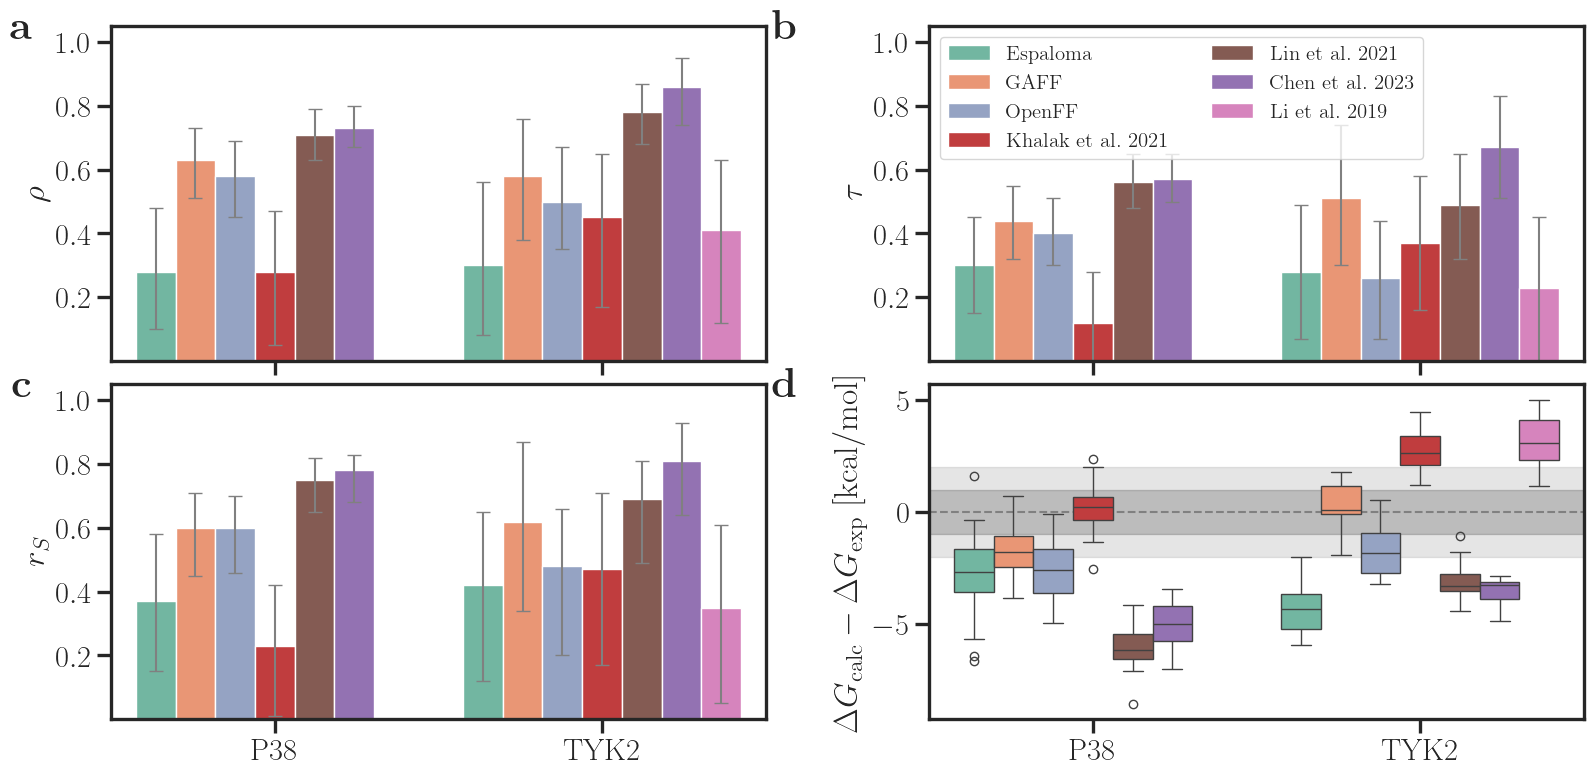

In [4]:
scale = 2  
sns.set_theme(
    style="ticks", 
    font_scale=scale,
    rc={
        "axes.linewidth": 1.2 * scale,
        # "lines.linewidth": 1.1 * scale
        }
)

# Make ticks thicker/longer in proportion to font scaling
plt.rcParams.update({
    "xtick.major.size": 5 * scale,   # length of major ticks
    "ytick.major.size": 5 * scale,
    "xtick.major.width": 1.2 * scale,  # thickness of major ticks
    "ytick.major.width": 1.2 * scale,
})
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(19, 9), sharex=True)

plot_stats(ax=axs[0,0],data=stats_data, contribution='pearson', legend=None)

plot_stats(ax=axs[0,1],data=stats_data, contribution='kendall', legend='auto')

plot_stats(ax=axs[1,0],data=stats_data, contribution='spearman', legend=None)


axs[0, 1].sharey(axs[0, 0])
axs[1, 0].sharey(axs[0, 0])
axs[0,0].set(ylim=[0,1.05])
axs[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[0,1].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[1,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])


axs[1,1].axhline(0, color='gray', linestyle='--')

plot_range = [-1*v for v in range(5, 1, -1)] + list(range(15))
axs[1,1].fill_between(plot_range, -1, 1, color='black', alpha=0.2,)#label=r'$\pm 1 \mathrm{~kcal/mol}$')
axs[1,1].fill_between(plot_range, -2, 2, color='gray', alpha=0.2,)#label=r'$\pm 2 \mathrm{~kcal/mol}$')


plot_ff(ax=axs[1,1], data=diff_data, contribution='diff', legend=None)
axs[0,1].get_legend().set_title(None)
axs[0,1].legend(ncol=2, loc='best', fontsize=15)  # Adjust legend position if needed

# Add subplot labels
labels = ['a', 'b', 'c', 'd']
for ax, label in zip(axs.flat, labels):
    if label in ['b', 'd']:
        if any(axs[1,1].get_yticks() <= -10):
            x_position = -0.2
            wspace = 0.25
        else:
            x_position = -0.15
            wspace = 0.2
    else:
        x_position = -0.12
    
    ax.text(x_position, 1.05, f"$\\mathbf{{{label}}}$", transform=ax.transAxes, 
            fontsize=30, va='top', ha='right')

fig.subplots_adjust(wspace=wspace, hspace=0.07)

fig.savefig('summary/external/mbar-stats-p38-tyk2-validation.pdf',
            bbox_inches="tight",
            pad_inches=0.05,
            transparent=False)